In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import FileLink, display

In [2]:
sns.set(rc={'axes.facecolor': '#e9eef2'}, style='darkgrid')


In [3]:
base_dir = "archive_data/Data/"

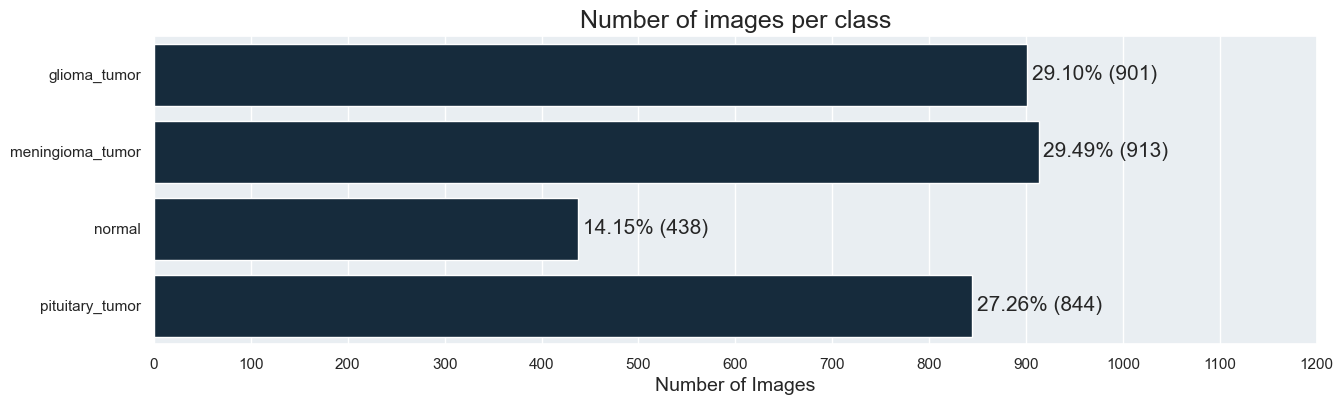

In [4]:
classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]

# Counting the number of images in each folder
counts = []
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]))

# Calculating the total number of images
total_count = sum(counts)

# Calculating the percentages
percentages = [(count / total_count) * 100 for count in counts]

# Set the figure size
plt.figure(figsize=(15, 4))

# Create a horizontal bar plot
ax = sns.barplot(y=classes, x=counts, orient='h', color='#102C42')

# Set x-axis interval (adjust as needed)
ax.set_xticks(range(0, max(counts) + 1, 1000))

# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            va="center", fontsize=15)

# Set the x-label for the plot
plt.xlabel('Number of Images', fontsize=14)

# Set x-axis interval
ax.set_xticks(range(0, max(counts) + 300, 100))

# Set the title and show the plot
plt.title("Number of images per class", fontsize=18)
plt.show()

In [5]:
# Lists to store heights and widths of all images
heights = []
widths = []

# Initialize sets to store unique dimensions
unique_dims = set()

# Loop over each class and their respective images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Add the dimensions (height, width, channels) to the set
            unique_dims.add((img.shape[0], img.shape[1]))
            
            # Append heights and widths for statistical calculations
            heights.append(img.shape[0])
            widths.append(img.shape[1])

# Check if all images have the same dimension
if len(unique_dims) == 1:
    print(f"All images have the same dimensions: {list(unique_dims)[0]}")
else:
    print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
    print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
    print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

All images have the same dimensions: (256, 256)


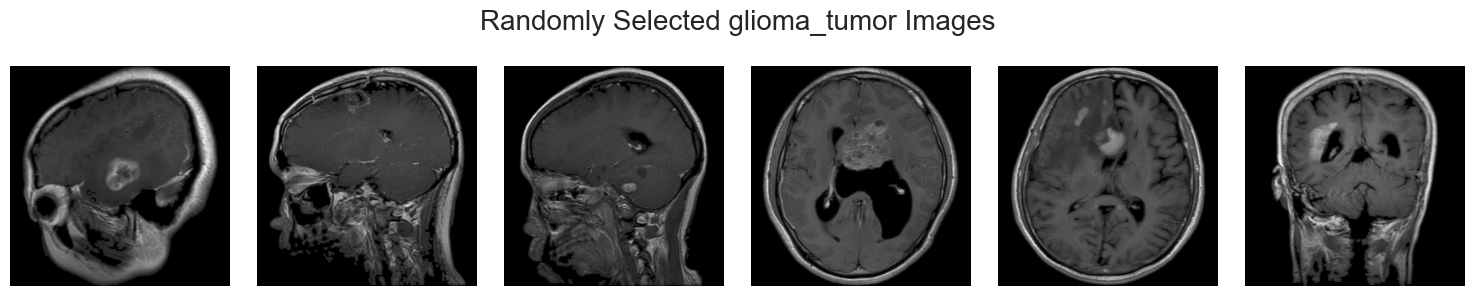

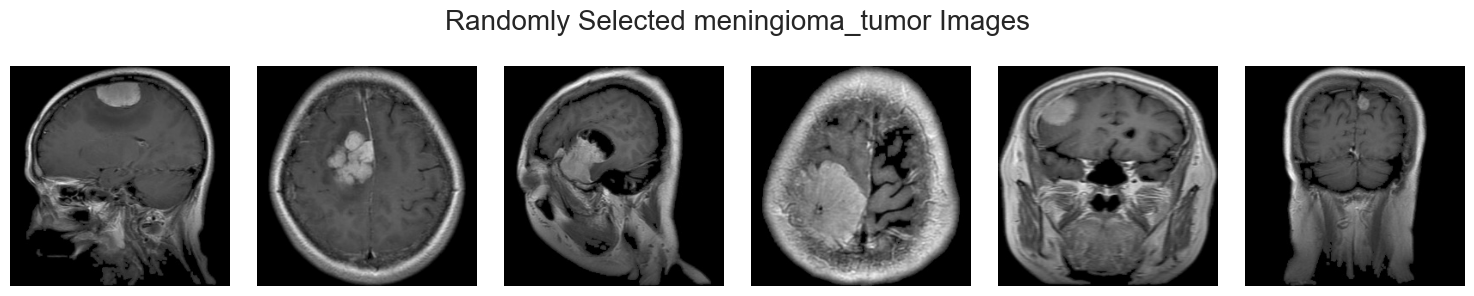

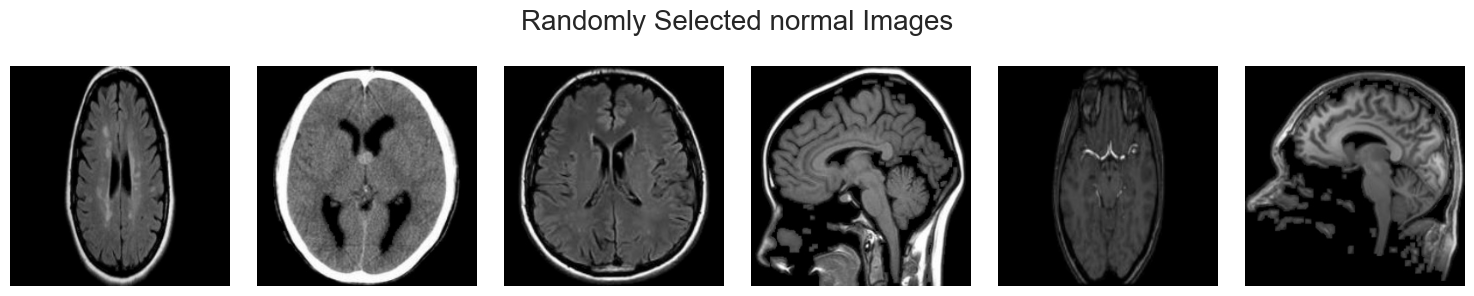

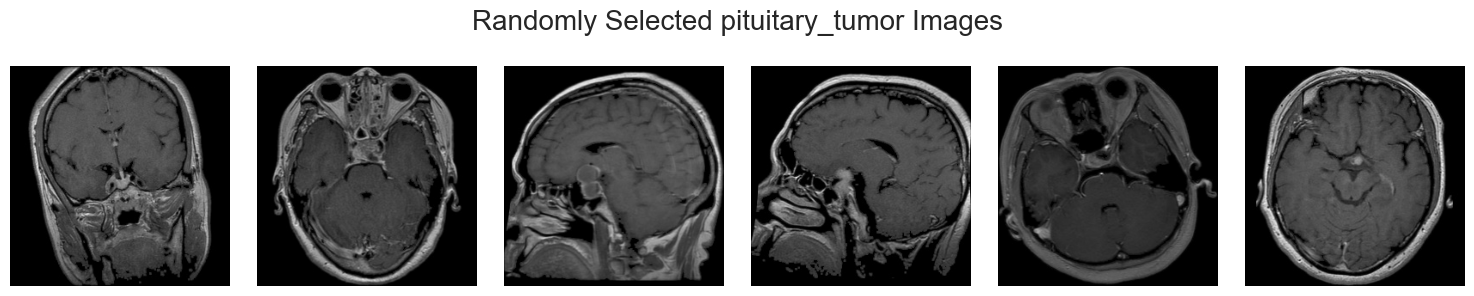

In [6]:
def plot_images(images, title):
    plt.figure(figsize=(15, 3)) 
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i+1)  # 1x5 subplot
        img = cv2.imread(img_path)
        # Convert the BGR image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Setting the random seed for reproducibility
np.random.seed(42)

# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images")

In [7]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop over each class and append the image file paths with their respective labels to the data list
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,archive_data/Data/glioma_tumor\G_1.jpg,glioma_tumor
1,archive_data/Data/glioma_tumor\G_10.jpg,glioma_tumor
2,archive_data/Data/glioma_tumor\G_100.jpg,glioma_tumor
3,archive_data/Data/glioma_tumor\G_101.jpg,glioma_tumor
4,archive_data/Data/glioma_tumor\G_102.jpg,glioma_tumor


In [8]:
print("Total number of images:", df.shape[0])

Total number of images: 3096


In [10]:
df['label'].value_counts()

label
meningioma_tumor    913
glioma_tumor        901
pituitary_tumor     844
normal              438
Name: count, dtype: int64

In [11]:
df['label'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3096 entries, 0 to 3095
Series name: label
Non-Null Count  Dtype 
--------------  ----- 
3096 non-null   object
dtypes: object(1)
memory usage: 24.3+ KB


In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

Training data shape: (2476, 2)
Validation data shape: (620, 2)


In [ ]:
# meningioma_tumor    913 -- 913 -- 913 -- 50
# glioma_tumor        901 -- 12 -- ddeduplication -25
# pituitary_tumor     844 -- 69 --30
# normal              438 -- 475 ---42

In [19]:
train_df['label'].value_counts(normalize=True) * 100

label
meningioma_tumor    29.483037
glioma_tumor        29.119548
pituitary_tumor     27.261712
normal              14.135703
Name: proportion, dtype: float64

In [24]:
train_df['label'].value_counts() / val_df['label'].value_counts()

label
meningioma_tumor    3.989071
glioma_tumor        4.005556
pituitary_tumor     3.994083
normal              3.977273
Name: count, dtype: float64

In [21]:
val_df.shape

(620, 2)

In [22]:
train_df.shape

(2476, 2)

In [25]:
def create_data_generators(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimensions=(224, 224)):
    """
    Creates and returns training and validation data generators with optional preprocessing.
    
    Parameters:
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - preprocessing_function (function, optional): Preprocessing function specific to a model. Defaults to None.
    - batch_size (int, optional): Number of images per batch for the generators. Defaults to 32.
    - image_dimensions (tuple, optional): Dimensions to which the images will be resized (height, width). Defaults to (224, 224).
    
    Returns:
    - train_generator (ImageDataGenerator): Generator for training data.
    - val_generator (ImageDataGenerator): Generator for validation data.
    
    Notes:
    - The validation generator does not use any augmentations.
    - If provided, the preprocessing function is applied to both generators.
    """

    # Define the training data generator with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rotation_range=20,                           # Rotate images by up to 20 degrees
        width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        zoom_range=0.10,                             # Zoom in/out by up to 10%
        horizontal_flip=True,                        # Allow horizontal flipping
        preprocessing_function=preprocessing_function
    )

    # Define the validation data generator without any augmentations
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )

    # Create an iterable generator for training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 # DataFrame containing training data
        x_col="filepath",                   # Column with paths to image files
        y_col="label",                      # Column with image labels
        target_size=image_dimensions,       # Resize all images to size of 224x224 
        batch_size=batch_size,              # Number of images per batch
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,                            # Seed for random number generator to ensure reproducibility
        shuffle=True                        # Shuffle the data to ensure the model gets a randomized batch during training
    )

    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,                   # DataFrame containing validation data
        x_col="filepath",                       
        y_col="label",
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,
        shuffle=False                       # Shuffling not necessary for validation data
    )
    
    # Return the training and validation generators
    return train_generator, val_generator


In [26]:
train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function=preprocess_input)

# Fetch a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Check the shape of the first image in the batch
print("Shape of the first image in the batch:", batch_images[0].shape)

Found 2476 validated image filenames belonging to 4 classes.
Found 620 validated image filenames belonging to 4 classes.
Shape of the first image in the batch: (224, 224, 3)


In [27]:
class_indices = train_generator.class_indices

# Sorting the class indices to get the list of class names in the correct order
class_names = sorted(class_indices, key=class_indices.get)
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

In [28]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



94668760/94668760 [==============================] - 26s 0us/step


In [29]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [38]:
def train_model(model, train_df, val_df, preprocessing_function, image_dimensions=(224, 224), batch_size=28, num_epochs=None):
    """
    Creates and returns training and validation data generators with optional preprocessing and augmentation.
    
    Parameters:
    - model: Model, a compiled instance of a Keras model to be trained.
    - train_df: DataFrame, the training data.
    - val_df: DataFrame, the validation data.
    - preprocessing_function: function, preprocessing function to be applied to input data.
    - image_dimensions: tuple, dimensions of the images (width, height).
    - batch_size: int, number of samples per batch of computation.
    - num_epochs: int, number of epochs to train the model.
    
    Returns:
    - model: The trained model instance.
    - history: A History object containing the training history.
    - val_generator: The validation data generator.
    """

    # Create data generators
    train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function, batch_size, image_dimensions)

    # Define the callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[reduce_lr, early_stopping]
    )
    
    return model, history, val_generator

In [39]:
model, history, val_generator = train_model(model, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=5)

Found 2476 validated image filenames belonging to 4 classes.
Found 620 validated image filenames belonging to 4 classes.
Epoch 1/5
89/89 [==============================] - 245s 3s/step - loss: 0.1902 - accuracy: 0.9354 - val_loss: 0.4957 - val_accuracy: 0.8581 - lr: 1.0000e-04
Epoch 2/5
89/89 [==============================] - 237s 3s/step - loss: 0.1576 - accuracy: 0.9463 - val_loss: 0.3106 - val_accuracy: 0.8935 - lr: 1.0000e-04
Epoch 3/5
89/89 [==============================] - 238s 3s/step - loss: 0.1299 - accuracy: 0.9600 - val_loss: 0.8988 - val_accuracy: 0.7710 - lr: 1.0000e-04
Epoch 4/5
89/89 [==============================] - 236s 3s/step - loss: 0.1001 - accuracy: 0.9641 - val_loss: 0.3239 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 5/5
89/89 [==============================] - 236s 3s/step - loss: 0.0845 - accuracy: 0.9725 - val_loss: 0.2158 - val_accuracy: 0.9452 - lr: 1.0000e-04


In [58]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
#     df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='#102C42', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='#102C42', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [59]:
df_loss = pd.DataFrame(history.history)
df_loss

,loss,accuracy,val_loss,val_accuracy,lr
0,0.190177,0.935380,0.495664,0.858065,0.0001
1,0.157596,0.946284,0.310616,0.893548,0.0001
2,0.129924,0.960016,0.898790,0.770968,0.0001
3,0.100089,0.964055,0.323895,0.909677,0.0001
4,0.084451,0.972536,0.215784,0.945161,0.0001


In [60]:
start_epoch=5
df_loss_2 = df_loss.iloc[start_epoch-1:]
df_loss_2

,loss,accuracy,val_loss,val_accuracy,lr
4,0.084451,0.972536,0.215784,0.945161,0.0001


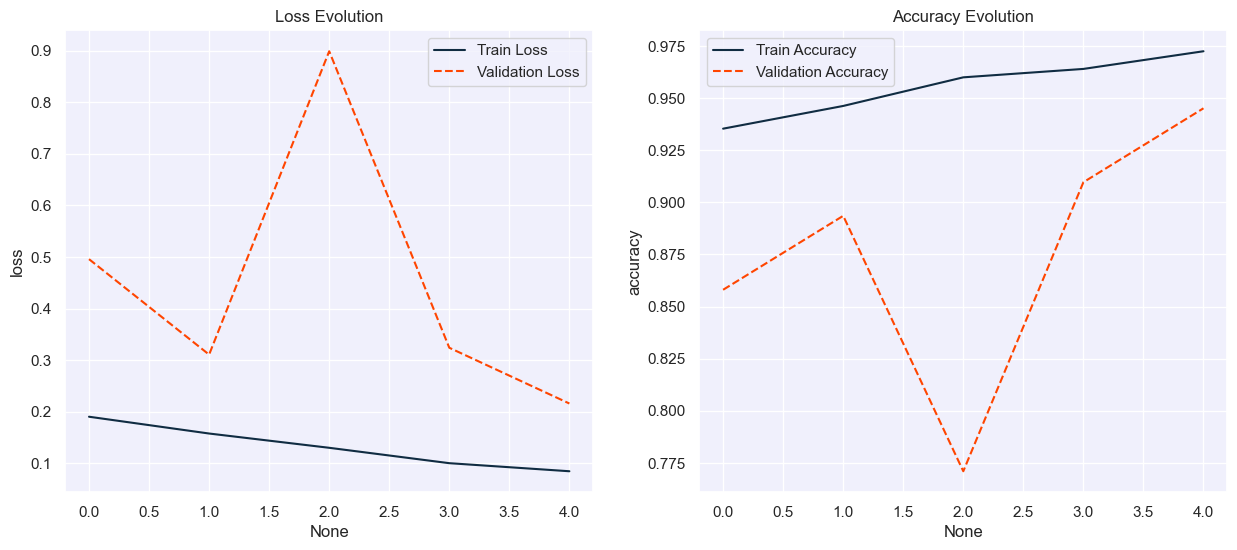

In [61]:
plot_learning_curves(history)

In [42]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

23/23 [==============================] - 16s 671ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96       180
meningioma_tumor       0.94      0.91      0.92       183
          normal       0.99      0.99      0.99        88
 pituitary_tumor       0.89      0.98      0.93       169

        accuracy                           0.95       620
       macro avg       0.95      0.95      0.95       620
    weighted avg       0.95      0.95      0.95       620





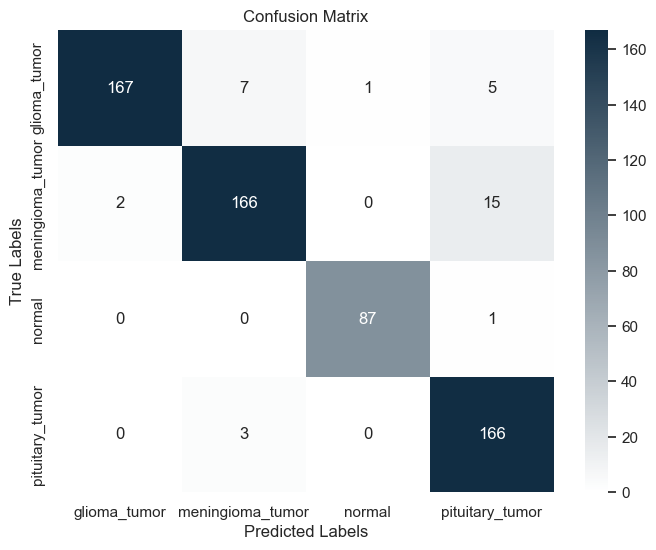

In [43]:
evaluate_model_performance(model, val_generator, classes)

In [44]:
model.save('ResNet50V2_model.h5')

In [90]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_images(model, image_paths, image_size, class_names):
    """
    Predicts classes for a list of image file paths.

    Parameters:
    - model: Trained TensorFlow/Keras model
    - image_paths: List of image file paths
    - image_size: Tuple (width, height) to resize images
    - class_names: List of class names

    Returns:
    - y_pred: Predicted class indices
    - y_pred_labels: Predicted class names
    - y_prob: Prediction probabilities
    """
    images = []

    # Load and preprocess each image
    for img_path in image_paths:
        img = load_img(img_path, target_size=image_size)  # Load and resize image
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = img_array / 255.0  # Normalize (assuming model was trained with normalization)
        images.append(img_array)

    # Convert list to NumPy array
    
    images = np.array(images)

    # Predict probabilities
    y_prob = model.predict(images)

    # Get predicted class indices
    y_pred = np.argmax(y_prob, axis=1)

    # Map indices to class labels
    y_pred_labels = [class_names[i] for i in y_pred]

    return y_pred, y_pred_labels, y_prob

# Example Usage:
# class_names = ['cat', 'dog', 'horse', 'elephant']  # Define class names
# image_paths = ["test1.jpg", "test2.jpg"]  # List of image file paths
# y_pred, y_pred_labels, y_prob = predict_images(model, image_paths, (224, 224), class_names)
# print("Predicted Labels:", y_pred_labels)


In [91]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

In [93]:
output = predict_images( model, ["archive_data/Data/glioma_tumor/G_100.jpg"], (224, 224), class_names)

1/1 [==============================] - 0s 69ms/step


In [99]:
result = " ".join(x for x in output[1])
result

'meningioma_tumor'